# # DATA EXPLORATION AND MODELING FOR ECG DATA

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalAveragePooling1D, LeakyReLU

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle

## Load the data

In [2]:
# Load the data from the directory with a sampling rate of 100 Hz using the function load_data_from_directory from data_loading_utils script
from data_loading_utils import load_data_from_directory

X, Y, df = load_data_from_directory("data/", sampling_rate=100)

## Data Exploration

In [3]:
# Display the data
df.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [4]:
# Check the Y data details
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


In [5]:
# Check the Y data details
Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19683 entries, 1 to 21837
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    19683 non-null  float64
 1   age                           19683 non-null  float64
 2   sex                           19683 non-null  int64  
 3   height                        6372 non-null   float64
 4   weight                        8693 non-null   float64
 5   nurse                         18312 non-null  float64
 6   site                          19668 non-null  float64
 7   device                        19683 non-null  object 
 8   recording_date                19683 non-null  object 
 9   report                        19683 non-null  object 
 10  scp_codes                     19683 non-null  object 
 11  heart_axis                    11903 non-null  object 
 12  infarction_stadium1           4479 non-null   object 
 13  infarc

In [6]:
# As a label, we will use the diagnostic_superclass column filtered by diagnostic confidence (threshold = 70)
Y['diagnostic_superclass'].value_counts()

diagnostic_superclass
[NORM]    8748
[CD]      3286
[STTC]    3093
[MI]      3034
[HYP]      871
[]         651
Name: count, dtype: int64

### Cardiac Diagnoses

#### NORM (Normal ECG)
- **Description**: This diagnosis indicates a normal electrocardiogram (ECG), meaning there are no significant abnormalities in the heart's electrical activity. The heart rhythm and waveforms fall within the typical range for a healthy individual.

#### MI (Myocardial Infarction)
- **Description**: Myocardial Infarction, commonly known as a heart attack, is characterized by the interruption of blood flow to a part of the heart, causing damage to the heart muscle. On an ECG, it may present as ST elevation, T wave inversion, or the development of Q waves, among other changes.

#### STTC (ST/T Change)
- **Description**: ST/T changes refer to abnormalities in the ST segment and T wave of the ECG. These changes can indicate various conditions, such as ischemia (reduced blood flow to the heart), electrolyte imbalances, or other cardiac pathologies. The specific nature of the change provides clues about the underlying condition.

#### CD (Conduction Disturbance)
- **Description**: Conduction disturbances involve abnormalities in the electrical conduction system of the heart, which can affect the timing and coordination of heartbeats. Examples include bundle branch blocks, atrioventricular (AV) blocks, and other forms of heart block. These are reflected on the ECG as altered intervals and waveforms.

#### HYP (Hypertrophy)
- **Description**: Hypertrophy refers to the thickening of the heart muscle, typically the result of increased workload or pressure. It is commonly seen in conditions such as hypertension or valvular heart disease. On an ECG, hypertrophy may present as increased voltage of QRS complexes, prolonged QRS duration, and changes in the ST segment and T waves.

This structured format categorizes the diagnoses based on their unique identifier, abbreviation, and a detailed description of each condition.

#### Main points
The dataset consists of 21837 ECG recordings, each with 12 leads.
The ECGs are sampled at 100 Hz, with a duration of 10 seconds.
The dataset includes 5 diagnostic superclass categories.
the dataset is imbalanced, with some classes having a large number of samples, while others have very few.
there are 651 missing values in the diagnostic superclass categories, which are represented as NaNs.

## Data Preprocessing

In [7]:
# Preprocess the data using the preprocess_data function from the data_loading_utils script
from data_loading_utils import preprocess_data
X, y = preprocess_data(X, Y)

In [8]:
# We will remove the samples with missing values (651) in the diagnostic superclass categories from the dataset.
#According to the dataset documentation - there are 410 samples for which no diagnostic statement is given, which are mainly pacemaker ECGs. The missing values in the diagnostic superclass are equally distributed across all folds
y['diagnostic_superclass'].value_counts()

diagnostic_superclass
[NORM]    8748
[CD]      3286
[STTC]    3093
[MI]      3034
[HYP]      871
Name: count, dtype: int64

In [9]:
# To simplify the problem, we will focus on binary classification between 'NORMAL' and 'MI' classes. We will filter the data to include only these classes.
y['diagnostic_binary'].value_counts()

diagnostic_binary
NORMAL    15998
MI         3034
Name: count, dtype: int64

## Data Splitting

In [10]:
# Import get_train_test_split function from the data_loading_utils script
from data_loading_utils import get_train_test_split

In [11]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test, X_val, y_val = get_train_test_split(X, y, test_fold=10, validation=True)

In [12]:
# Check the shape of the data
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((13325, 1000, 12),
 (1900, 1000, 12),
 (3807, 1000, 12),
 (13325,),
 (1900,),
 (3807,))

In [13]:
# Check the distribution of classes in the training, test, and validation sets
y_train.value_counts(), y_test.value_counts(), y_val.value_counts()

(diagnostic_binary
 NORMAL    11170
 MI         2155
 Name: count, dtype: int64,
 diagnostic_binary
 NORMAL    1623
 MI         277
 Name: count, dtype: int64,
 diagnostic_binary
 NORMAL    3205
 MI         602
 Name: count, dtype: int64)

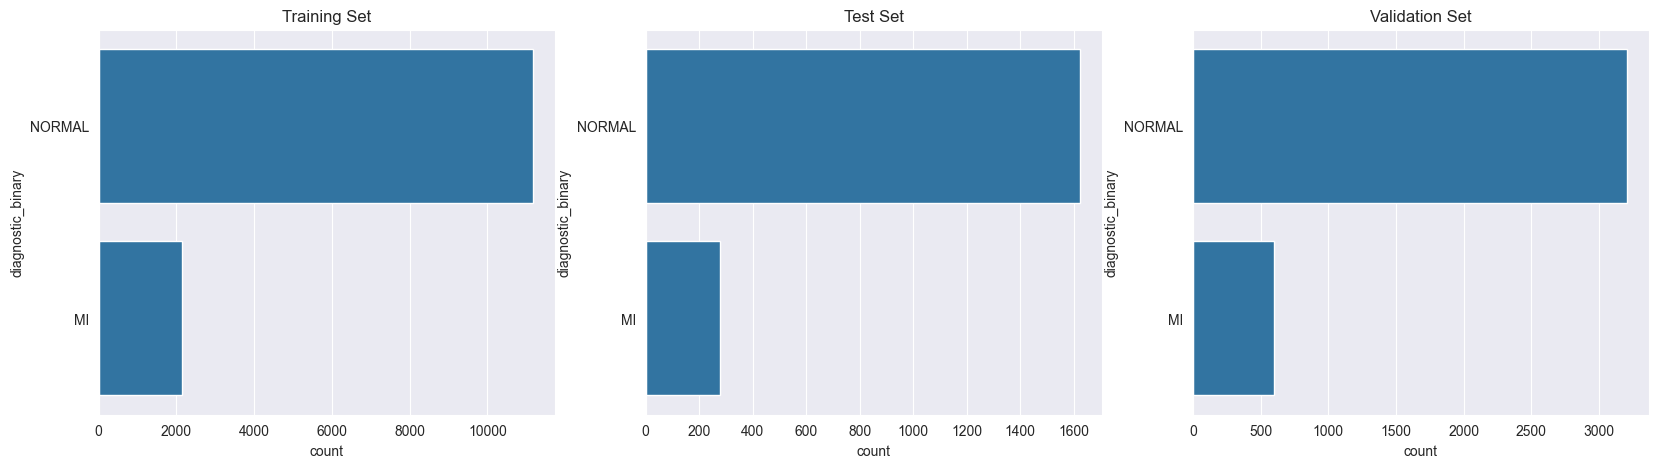

In [14]:
# vizualize the distribution of the classes in the training, test and validation set
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(y_train, ax=ax[0])
ax[0].set_title('Training Set')
sns.countplot(y_test, ax=ax[1])
ax[1].set_title('Test Set')
sns.countplot(y_val, ax=ax[2])
ax[2].set_title('Validation Set')
plt.show()

#### Based on the distribution of classes in the training, test, and validation sets, we can observe that the classes are imbalanced, with the 'NORMAL' class having a significantly larger number of samples compared to the 'MI' class. This imbalance can affect the model's ability to learn the underlying patterns in the data and may lead to biased predictions. To address this issue, we can use techniques such as class weighting, oversampling, or undersampling to balance the classes during training.

## Data Normalization

In [22]:
#  Create a function preprocess_signals that takes the training, validation, and test signals as input and standardizes the data using the StandardScaler from scikit-learn. The function should return the standardized signals and save the StandardScaler object to a file using pickle.
def preprocess_signals(X_train, X_validation, X_test, output_dir):
    # Standardize data such that mean 0 and variance 1
    ss = StandardScaler()
    ss.fit(np.vstack(X_train).flatten()[:,np.newaxis].astype(float))
    
    # Save Standardizer data
    with open(output_dir +'standard_scaler.pkl', 'wb') as ss_file:
        pickle.dump(ss, ss_file)

    return apply_standardizer(X_train, ss), apply_standardizer(X_validation, ss), apply_standardizer(X_test, ss)

In [15]:
# function to apply standardizer
def apply_standardizer(X, ss):
    X_tmp = []
    for x in X:
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp



# load the standardizer
# with open('models/standard_scaler.pkl', 'rb') as f:
#     ss = pickle.load(f)

# apply the standardizer
X_train, X_val, X_test = preprocess_signals(X_train, X_val, X_test, 'models/')


In [16]:
# load the standardizer
with open('models/standard_scaler.pkl', 'rb') as f:
    ss = pickle.load(f)

# apply the standardizer
X_train = apply_standardizer(X_train, ss)
X_val = apply_standardizer(X_val, ss)
X_test = apply_standardizer(X_test, ss)

## Label Encoding

In [18]:
# binary encode the labels
label_dict = {'NORMAL': 0, 'MI': 1}
y_train_label = y_train.map(label_dict)
y_test_label = y_test.map(label_dict)
y_val_label = y_val.map(label_dict)

In [20]:
# get the input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = y_train_label.nunique()
input_shape, num_classes

((1000, 12), 2)

In [22]:
# Convert labels to one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train_label, num_classes=num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val_label, num_classes=num_classes)

### Convolutional Neural Network

## Class Weights

In [23]:
# calculate class weights to handle class imbalance in the training data using the compute_class_weight function from scikit-learn
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_label), y=y_train_label)
class_weights_dict = {i: class_weights[i] for i in range(num_classes)}
class_weights_dict

{0: 0.5964637421665174, 1: 3.0916473317865427}

## Model Building

In [138]:
# import regularizers from keras
from tensorflow.keras.regularizers import l2

In [43]:
# Build the model
model1 = Sequential()

# Add 1D convolutional layers with LeakyReLU activation
for _ in range(5):
    model1.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_regularizer=l2(0.01), input_shape=input_shape if _ == 0 else None))
    model1.add(BatchNormalization())
    model1.add(LeakyReLU(negative_slope=0.01))
    model1.add(Dropout(0.3))

# Flatten the output before the fully connected layer
model1.add(Flatten())

# Fully connected layer with softmax activation
model1.add(Dense(units=2, activation='softmax'))  # Assuming 2 classes for the output

/Users/gala/PycharmProjects/Saturdays_FP/disease-prediction/dis/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
# create an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [110]:
# Compile the model
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(name='Recall', thresholds=0.3), # threshold for recall is set to 0.3 to account for class imbalance
        tf.keras.metrics.Precision(name='Precision'), 
        tf.keras.metrics.AUC(name='AUC',
        curve="ROC",
        dtype=None,
        thresholds=None),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.TruePositives(name="tp"),
    ])

In [142]:
# Display the model summary
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 1000, 32)       │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 1000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 1000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 1000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 1000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │        64,002 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 234,088 (914.41 KB)

 Trainable params: 77,922 (304.38 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 155,846 (608.78 KB)

## Model Training

In [88]:
# Define callbacks
callbacks = [EarlyStopping(monitor='val_AUC', patience=20, verbose=1, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_AUC', patience=20, verbose=1, min_lr=1e-6, restore_best_weights=True)]

In [112]:
model1.fit(X_train, y_train_oh, validation_data=(X_val, y_val_oh), epochs=50, batch_size=64, callbacks=callbacks, sample_weight= y_train_label.map(class_weights_dict))

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - AUC: 0.8329 - Precision: 0.8182 - Recall: 0.8583 - fn: 1195.2380 - fp: 1195.2380 - loss: 0.7188 - tn: 5555.9712 - tp: 5555.9712 - val_AUC: 0.8413 - val_Precision: 0.8411 - val_Recall: 0.8458 - val_fn: 605.0000 - val_fp: 605.0000 - val_loss: 0.6548 - val_tn: 3202.0000 - val_tp: 3202.0000 - learning_rate: 1.0000e-04
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - AUC: 0.8444 - Precision: 0.8406 - Recall: 0.8513 - fn: 1085.6238 - fp: 1085.6238 - loss: 0.6410 - tn: 5665.5859 - tp: 5665.5859 - val_AUC: 0.8405 - val_Precision: 0.8413 - val_Recall: 0.8429 - val_fn: 604.0000 - val_fp: 604.0000 - val_loss: 0.6424 - val_tn: 3203.0000 - val_tp: 3203.0000 - learning_rate: 1.0000e-04
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - AUC: 0.8328 - Precision: 0.8301 - Recall: 0.8423 - fn: 1127.8429 - fp: 1127.8429 - loss: 0.6571 - tn: 5623.3667 - tp: 5623.3667 - val_AUC: 0.8406 - val_Precision: 0.8421 - val_Recall: 0.8427 - val_fn:

## Training Results Visualization

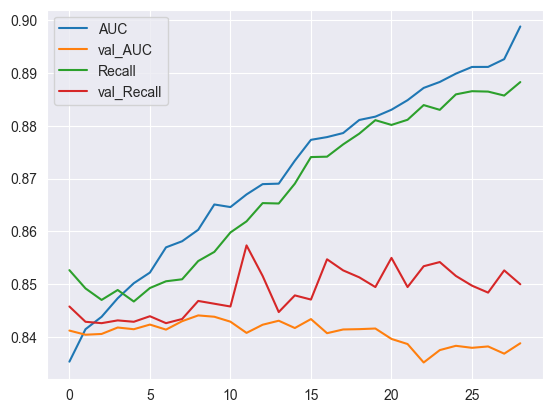

In [113]:
plt. plot(model1.history.history['AUC'])
plt.plot(model1.history.history['val_AUC'])
plt.plot(model1.history.history['Recall'])
plt.plot(model1.history.history['val_Recall'])
plt.legend(['AUC', 'val_AUC', 'Recall', 'val_Recall'])
plt.show()

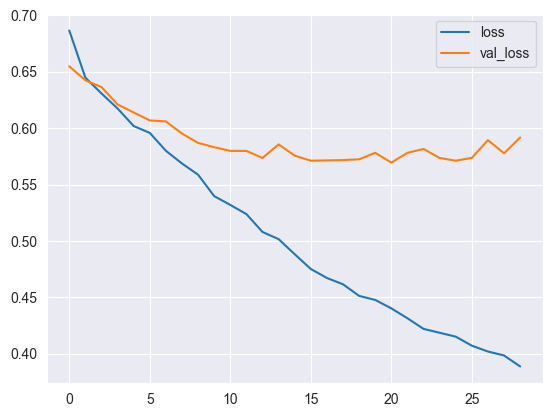

In [114]:
# loss and accuracy
plt.plot(model1.history.history['loss'])
plt.plot(model1.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Model Evaluation

In [115]:
# Evaluate the model
y_test_oh = tf.keras.utils.to_categorical(y_test_label, num_classes=num_classes)
model1.evaluate(X_test, y_test_oh, verbose=2)

60/60 - 2s - 27ms/step - AUC: 0.8502 - Precision: 0.8542 - Recall: 0.8579 - fn: 277.0000 - fp: 277.0000 - loss: 0.5715 - tn: 1623.0000 - tp: 1623.0000


[0.5714845657348633,
 0.8578947186470032,
 0.8542105555534363,
 0.8501933813095093,
 277.0,
 277.0,
 1623.0,
 1623.0]

#### The model achieves an AUC of 0.85 on the test set, indicating acceptable performance in distinguishing between the 'NORMAL' and 'MI' classes. The recall and precision metrics are also high (0.85), suggesting that the model can effectively identify positive cases (MI) while minimizing false positives.

## Save Model 

In [56]:
# save the model
model1.save('models/cnn_model.h5')

## Model Predictions

In [116]:
# predict the test data
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = pd.Series(y_pred)
y_pred

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


0       0
1       0
2       0
3       0
4       0
       ..
1895    0
1896    0
1897    0
1898    0
1899    0
Length: 1900, dtype: int64

In [88]:
# classification report
print(classification_report(y_test_label, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.74      0.79      1623
           1       0.16      0.29      0.20       277

    accuracy                           0.67      1900
   macro avg       0.51      0.51      0.50      1900
weighted avg       0.76      0.67      0.71      1900


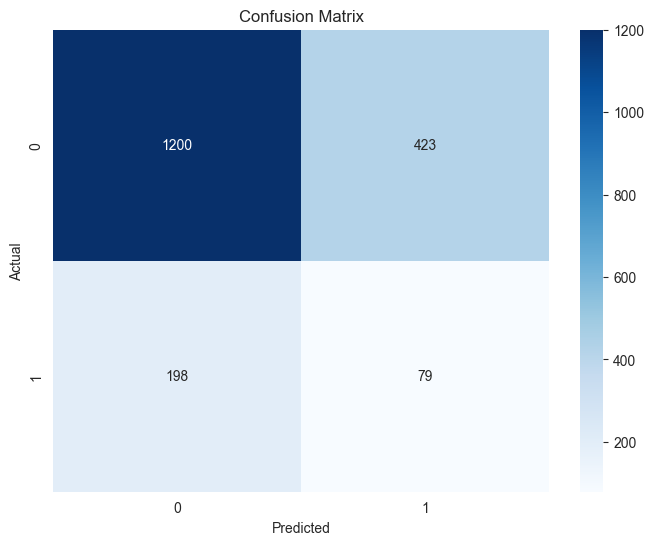

In [89]:
# confusion matrix
conf_matrix = confusion_matrix(y_test_label, y_pred)
# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()